In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from xgboost import XGBRegressor

In [2]:
df=pd.read_excel(r"../dataset/data.xlsx",sheet_name="Sheet1")
df

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350
...,...,...,...,...,...,...,...
4021,22,66,6,6.0,50,25.00,1.628000
4022,22,66,6,6.0,75,25.00,2.714000
4023,22,66,6,6.0,100,25.00,2.879000
4024,22,66,6,7.5,0,25.00,0.602680


In [3]:
df.shape

(4026, 7)

In [4]:
df.head()

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

print(normalized_df)

      Number of Storeys(NS)  Height of Structure(HS)  Number of Spans(HSP)  \
0                       0.0                      0.0                   0.0   
1                       0.0                      0.0                   0.0   
2                       0.0                      0.0                   0.0   
3                       0.0                      0.0                   0.0   
4                       0.0                      0.0                   0.0   
...                     ...                      ...                   ...   
4021                    1.0                      1.0                   1.0   
4022                    1.0                      1.0                   1.0   
4023                    1.0                      1.0                   1.0   
4024                    1.0                      1.0                   1.0   
4025                    1.0                      1.0                   1.0   

      Length of Spans (LS)  Opening percentage (OP)  \
0       

In [6]:
normalized_df.keys()

Index(['Number of Storeys(NS)', 'Height of Structure(HS)',
       'Number of Spans(HSP)', 'Length of Spans (LS)',
       'Opening percentage (OP)', 'Masonry wall Stiffeness Et (MS)',
       'Period (P)'],
      dtype='object')

In [7]:
X=normalized_df.drop("Period (P)" ,axis=1)

In [8]:
y=normalized_df["Period (P)"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99)

In [13]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import optuna.integration.lightgbm as oplgb
import xgboost as xgb

In [14]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import KFold,cross_validate
from bayes_opt import BayesianOptimization
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss


In [15]:
param_grid_simple={'n_estimators':hp.quniform('n_estimators',800,1500,50)
                   ,'max_depth':hp.quniform('max_depth',2,10,1)
                   ,'subsample':hp.uniform('subsample',0.01,1),
                   'learning_rate': hp.uniform('learning_rate', 0.01, 0.999),
                  }



In [16]:
def hyperopt_objective(params):
    model=XGBRegressor(n_estimators=int(params['n_estimators'])
              ,max_depth=int(params['max_depth'])
              ,subsample=int(params['subsample'])
              ,learning_rate=params['learning_rate']
              ,random_state=99
              ,n_jobs=4)
    
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                   ,error_score='raise')
    
    return np.mean(abs(validate_loss['test_score']))


In [17]:
def param_hyperopt(max_evals=100):
    trials=Trials()
    
    early_stop_fn=no_progress_loss(100) 
    params_best=fmin(hyperopt_objective 
                     ,space=param_grid_simple 
                     ,algo=tpe.suggest 
                     ,max_evals=max_evals 
                     ,trials=trials 
                     ,early_stop_fn=early_stop_fn 
                    )
    
    print('best parmas:',params_best)
    return params_best,trials


In [18]:
def hyperopt_validation(params):
    model=XGBRegressor(n_estimators=int(params['n_estimators'])
              ,max_depth=int(params['max_depth'])
              ,subsample=int(params['subsample'])
              ,learning_rate=params['learning_rate'
              ,random_state=99
              ,n_jobs=4)
        
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                  )
    
    return np.mean(abs(validate_loss['test_score']))


In [19]:
# Start time
start_time = time.time()

params_best, trials = param_hyperopt(100)

hyperopt_validation(params_best)

trials.trials[0]

trials.losses()[:10]
# End time
end_time = time.time()
# Calculate total time
total_time = end_time - start_time
print("Total time taken: ", total_time)

100%|██████████| 100/100 [04:17<00:00,  2.58s/trial, best loss: 0.2210422943334065]
best parmas: {'learning_rate': 0.525420603734754, 'max_depth': 9.0, 'n_estimators': 1300.0, 'subsample': 0.5682709282858943}
Total time taken:  259.5334963798523


# XGBoost

In [20]:
import xgboost as xgb
params_best['max_depth'] = int(params_best['max_depth'])
params_best['n_estimators'] = int(params_best['n_estimators'])
params_best['subsample'] = int(params_best['subsample'])
xgb_reg= XGBRegressor(**params_best)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5254, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [22]:
y_pred=xgb_reg.predict(X_test)
y_pred1=xgb_reg.predict(X_val)
y_pred2=xgb_reg.predict(X_train)

In [23]:
print("mean_absolute_error:", mean_absolute_error(y_val, y_pred1))
print("mean_squared_error:", mean_squared_error(y_val, y_pred1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred1)))
print("r2 score:", r2_score(y_val, y_pred1))

mean_absolute_error: 0.005174915480282769
mean_squared_error: 0.0001143921728254389
rmse: 0.010695427659773072
r2 score: 0.9977056778341475


In [24]:
print("mean_absolute_error:", mean_absolute_error(y_train, y_pred2))
print("mean_squared_error:", mean_squared_error(y_train, y_pred2))
print("rmse:", sqrt(mean_squared_error(y_train, y_pred2)))
print("r2 score:", r2_score(y_train, y_pred2))

mean_absolute_error: 0.0005350445069172273
mean_squared_error: 1.5590072464939621e-06
rmse: 0.001248602116966795
r2 score: 0.9999681284302259


In [25]:
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 0.004931890241636281
mean_squared_error: 9.555912188921585e-05
rmse: 0.009775434613827452
r2 score: 0.9981347280094408


In [26]:
from yellowbrick.regressor import PredictionError

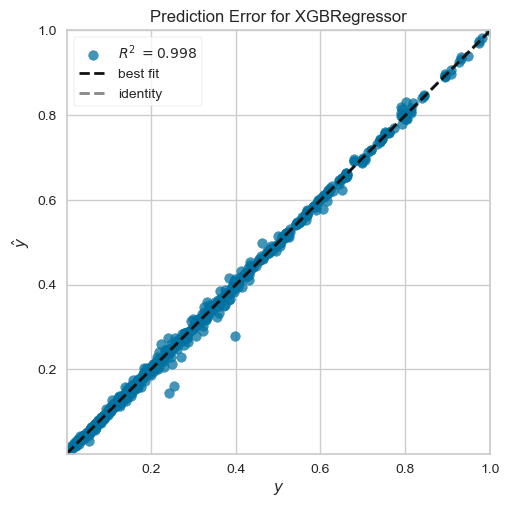

<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [27]:
visualizer = PredictionError(xgb_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()